In [23]:
import os

import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score 
import seaborn as sns
import swifter
import duckdb
from IPython.display import clear_output
con = duckdb.connect()


In [2]:
for i in range(10):
    cwd = os.getcwd()
    r, c = os.path.split(cwd)
    if c == 'repo':
        print(f'new working dir: {cwd}')
        break
    os.chdir(r)

new working dir: c:\Users\aknof\Documents\GT\CSE_6250_BD4H\Project\repo


In [10]:
feat_df = pd.read_csv(os.path.join('data', 'consumed', 'dense_feature.csv')).rename(columns={'SUBJECT_ID': 'id'})
feat_df.head()

,id,F0,F1,F2,F3,F4,F5,F6,F7,F8,...,F990,F991,F992,F993,F994,F995,F996,F997,F998,F999
0,2,0.052208,0.105053,-0.100350,-0.042010,0.038894,0.086565,-0.013481,0.092487,-0.137238,...,-0.117032,0.095805,-0.065410,0.052102,0.011810,0.043094,0.161437,-0.060491,0.045529,-0.112069
1,3,-0.026232,0.133410,-0.062311,-0.087948,0.065563,0.046006,0.000258,0.041759,-0.084532,...,-0.027079,0.108531,-0.076217,-0.012878,-0.154045,0.055077,-0.005913,-0.047781,0.008047,0.002012
2,4,-0.070908,-0.068187,-0.048338,-0.148972,0.046354,0.132966,0.026155,-0.030616,-0.017034,...,0.066733,0.121087,-0.008704,0.005541,-0.010806,0.072195,0.054540,-0.076624,-0.072656,0.062275
3,5,0.015193,0.108114,-0.059156,-0.062374,0.093193,0.095682,0.023337,-0.033058,-0.080769,...,0.148111,0.098194,0.032282,0.187567,0.015080,0.002625,0.079945,-0.008672,0.012438,-0.078997
4,6,0.120460,0.116227,0.073314,-0.092273,-0.034998,0.050711,-0.036398,0.054734,-0.137434,...,0.046523,0.110233,-0.028940,0.135374,0.017890,0.008272,0.142290,0.130462,0.147706,0.051248


In [4]:
tgt_df = pd.read_csv(os.path.join('data', 'consumed', 'i2b2_patient-svm_targets.csv')).reset_index()
tgt_df.head()

,level_0,index,id,judgment,disease_name,source_type,split,source_file
0,0,0,3,Y,Asthma,intuitive,test,obesity_standoff_annotations_test.xml
1,1,1,5,N,Asthma,intuitive,test,obesity_standoff_annotations_test.xml
2,2,2,7,N,Asthma,intuitive,test,obesity_standoff_annotations_test.xml
3,3,3,9,Y,Asthma,intuitive,test,obesity_standoff_annotations_test.xml
4,4,4,10,N,Asthma,intuitive,test,obesity_standoff_annotations_test.xml


In [5]:
tgt_df_std = con.execute("""
select *
,dense_rank() over (order by judgment) as target
from tgt_df
order by level_0
""").df()
tgt_df_std.head()

,level_0,index,id,judgment,disease_name,source_type,split,source_file,target
0,0,0,3,Y,Asthma,intuitive,test,obesity_standoff_annotations_test.xml,4
1,1,1,5,N,Asthma,intuitive,test,obesity_standoff_annotations_test.xml,1
2,2,2,7,N,Asthma,intuitive,test,obesity_standoff_annotations_test.xml,1
3,3,3,9,Y,Asthma,intuitive,test,obesity_standoff_annotations_test.xml,4
4,4,4,10,N,Asthma,intuitive,test,obesity_standoff_annotations_test.xml,1


In [24]:
con.execute("""
select disease_name
,source_type
,count(*) cnt
,count(distinct id) as patient_cnt
from tgt_df_std
group by disease_name, source_type
having count(*) <> count(distinct id)
""").df()

,disease_name,source_type,cnt,patient_cnt


In [6]:
tgt_set_df = con.execute("""
select disease_name
,source_type
,count(*) cnt
,count(distinct id) as patient_cnt
from tgt_df_std
group by disease_name, source_type
""").df()
tgt_set_df.head()

,disease_name,source_type,cnt,patient_cnt
0,Asthma,intuitive,1153,1153
1,CAD,intuitive,1119,1119
2,CHF,intuitive,1065,1065
3,Depression,intuitive,1174,1174
4,Diabetes,intuitive,1162,1162


In [15]:
class I2b2Svc:
    def __init__(self, disease_name, source_type):
        self.disease_name = disease_name
        self.source_type = source_type
        self.x_train, self.y_train, self.x_test, self.y_test = None, None, None, None 
        self.score = None

    def clean_df(self, df):
        cols = ['id', 'split']
        return df.drop(columns=cols)

    def get_x_y(self, feat_df, tgt_df):
        tgt_iter_df = con.execute(f""" 
        select id, split, target
        from tgt_df t
        where disease_name = '{self.disease_name}' 
        and source_type = '{self.source_type}' 
        and exists (select 1 from feat_df f where t.id = f.id)
        """).df()
        feat_iter_df = con.execute("""
        select t.split, f.* 
        from feat_df f 
        join tgt_iter_df t 
        on f.id = t.id
        """).df()
        self.x_train = self.clean_df(con.execute(""" 
        select *
        from feat_iter_df
        where split = 'training'
        """).df())
        self.y_train = self.clean_df(con.execute(""" 
        select *
        from tgt_iter_df
        where split = 'training'
        """).df())
        self.x_test = self.clean_df(con.execute(""" 
        select *
        from feat_iter_df
        where split = 'test'
        """).df())
        self.y_test = self.clean_df(con.execute(""" 
        select *
        from tgt_iter_df
        where split = 'test'
        """).df())

    def classify(self):
        clf = LinearSVC(class_weight='balanced')
        clf.fit(self.x_train, self.y_train)
        pred = clf.predict(self.x_test)
        self.score = f1_score(self.y_test, pred, average='macro')

    def run(self, feat_df, tgt_df):
        self.get_x_y(feat_df, tgt_df)
        self.classify()
        clear_output()
        return {'disease': self.disease_name, 'target_type': self.source_type, 'score': self.score}



In [12]:
results = []

def run_svm_set(x):
    disease_name, source_type = x
    if disease_name == 'disease_name':
        pass
    else:
        m = I2b2Svc(disease_name, source_type)
        r = m.run(feat_df, tgt_df_std)
        results.append(r)

In [28]:
results = []
tgt_set_df[['disease_name', 'source_type']].swifter.apply(run_svm_set, axis=1)
clear_output()

In [29]:
results[:3]

[{'disease': 'Depression',
  'target_type': 'textual',
  'score': 0.5092701995384223},
 {'disease': 'Hypertriglyceridemia',
  'target_type': 'textual',
  'score': 0.4936708860759494},
 {'disease': 'Depression',
  'target_type': 'textual',
  'score': 0.5092701995384223}]

In [30]:
result_df = pd.DataFrame(results)
result_df.head()

,disease,target_type,score
0,Depression,textual,0.509270
1,Hypertriglyceridemia,textual,0.493671
2,Depression,textual,0.509270
3,Hypertriglyceridemia,textual,0.493671
4,Depression,textual,0.509270


In [35]:
con.execute("""
select min(score), max(score), avg(score)
from result_df
""").df()

,min(score),max(score),avg(score)
0,0.234657,0.512695,0.420615


<AxesSubplot:xlabel='score', ylabel='disease'>

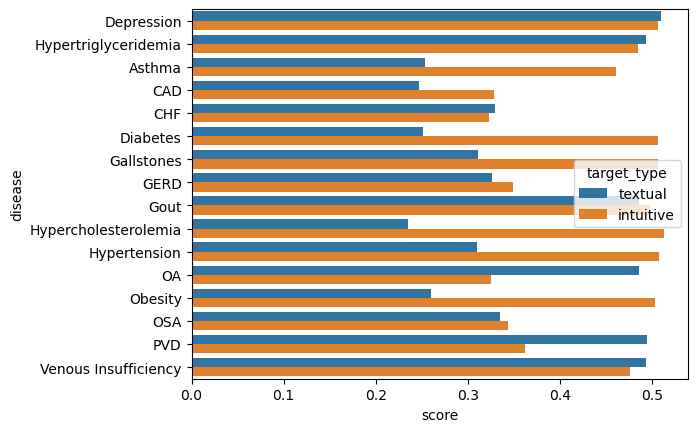

In [32]:
sns.barplot(data=result_df, x='score', y='disease', hue='target_type')